In [16]:
import matplotlib.pyplot as plt
import sys
import time
import scipy.io as io
import os
from os import listdir
import glob
import time

import cv2
import numpy as np
from opt_flow import draw_flow

import math
from skimage import data
from skimage import filters
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import binary_closing, binary_opening, binary_dilation, disk,remove_small_objects,label
from skimage.color import label2rgb
from skimage.morphology import remove_small_holes, binary_erosion
from skimage.segmentation.boundaries import find_boundaries
from skimage.segmentation import clear_border
from skimage.measure import EllipseModel
from skimage.draw import ellipse
from skimage.filters import threshold_otsu, threshold_local
from scipy import ndimage as ndi
from skimage.measure import label, regionprops
from skimage import transform as tf
from scipy.signal import find_peaks
from skimage import filters
from skimage.filters import gaussian
import csv

from skimage import exposure
from skimage.morphology import reconstruction

from skimage.feature import peak_local_max
from scipy import ndimage as ndi

from skimage.segmentation import watershed
from scipy.fftpack import fftn,fftfreq
from skimage.exposure import equalize_adapthist
from skimage.segmentation import clear_border

def cellSegmentation(subfolder,block_size=25,offset=0.02):

    imageNameRoot =  subfolder  + "\\tiff\\*.tif"
        #B9, C2,C4
    (dirName,videoFileName) = os.path.split(subfolder)

    imageNameRoot0 = dirName
    imageNames = sorted(glob.glob(imageNameRoot))

    img0 = cv2.imread(imageNames[0])
    
    img_enhance = equalize_adapthist(img0, kernel_size=block_size)
    img_gray=img_enhance[:,:,0]
    
    local_thresh = threshold_local(img_gray, block_size, offset=0.02)
    binary_local = img_gray < local_thresh
  
    cellMask1 = binary_closing(binary_local,disk(1))
    cellMask2 = ndi.binary_fill_holes(cellMask1)
    
    cellMask3 =  remove_small_objects(cellMask2,50)

    cellMask4 = binary_closing(cellMask3,disk(2))
    cellMask5 = ndi.binary_fill_holes(cellMask4)
    cellMask6 = binary_erosion(cellMask5,disk(1))
    cellMask7 = binary_opening(cellMask6,disk(3))

    cellMask8 =  remove_small_objects(cellMask7,200)
    
    cellMask9 = binary_opening(cellMask8,disk(3))

    distance = ndi.distance_transform_edt(cellMask9)
    coords = peak_local_max(distance, min_distance=3,footprint=np.ones((3, 3)), labels=cellMask9)
    mask = np.zeros(distance.shape, dtype=bool)
    mask[tuple(coords.T)] = True
    markers, _ = ndi.label(mask)
    labels = watershed(-distance, markers, mask=cellMask8)
    seg = labels>0
    seg = binary_opening(seg,disk(5))
    
    return seg

def movingCellDetection(subfolder,block_size=21,offset=0.015,fps=100.0,interFrame=10):

    ds_time = interFrame 

    imageNameRoot =  subfolder  + "\\tiff\\*.tif"
        #B9, C2,C4
    (dirName,videoFileName) = os.path.split(subfolder)

    imageNameRoot0 = dirName
    imageNames = sorted(glob.glob(imageNameRoot))
    imageNum = len(imageNames)

    fps=100.0
    if imageNum>1500:
        fps=200.0
        
    kk = 0
    stackLen = len(imageNames)//ds_time
    img0 = cv2.imread(imageNames[0])
    img1 = cv2.cvtColor(img0, cv2.COLOR_BGR2GRAY)
    reg_hei,reg_wid = img1.shape
    imgStack = np.zeros([reg_hei, reg_wid, int(stackLen)+1],dtype =  np.float32)

    for ii in range(0,imageNum,ds_time):
        img0 = cv2.imread(imageNames[ii])
        img1 = cv2.cvtColor(img0, cv2.COLOR_BGR2GRAY)
        imgStack[:,:,kk]=img1
        kk = kk+1
        
    imgStack.astype(np.float32)
    
    # sample spacing
    T = 1.0 / stackLen*ds_time

    # Number of sample points
    N = stackLen
    xf = fftfreq(N, T)[:N//2]

    freq_range = np.where((np.array(xf)>0.5) & (np.array(xf)<1.5)) ##only check freqency domain from 0.5hz to 1.5hz
    
    imgStackFFT =np.abs(fftn(imgStack, axes=2))
    imgFFTMax= np.max(imgStackFFT[:,:,freq_range[0]],axis=2)
    
    th_log=np.mean(np.log(imgFFTMax))+3*np.std(np.log(imgFFTMax))
    
    ###local_thresh = threshold_local(imgFFTMax, block_size, offset)
    
    
    cellMask0 = np.log(imgFFTMax)>th_log 
    
    cellMask1 = binary_closing(cellMask0,disk(1))
    cellMask2 = ndi.binary_fill_holes(cellMask1)
    
    cellMask3 =  remove_small_objects(cellMask2,50)

    cellMask4 = binary_closing(cellMask3,disk(2))
    cellMask5 = ndi.binary_fill_holes(cellMask4)
    cellMask6 = binary_erosion(cellMask5,disk(1))
    cellMask7 = binary_opening(cellMask6,disk(3))

    cellMask8 =  remove_small_objects(cellMask7,200)
    
    cellMask9 = binary_opening(cellMask8,disk(3))

    distance = ndi.distance_transform_edt(cellMask9)
    coords = peak_local_max(distance, min_distance=3,footprint=np.ones((3, 3)), labels=cellMask9)
    mask = np.zeros(distance.shape, dtype=bool)
    mask[tuple(coords.T)] = True
    markers, _ = ndi.label(mask)
    labels = watershed(-distance, markers, mask=cellMask8)
    seg = labels>0
    seg = binary_opening(seg,disk(5))
    seg = binary_dilation(seg,disk(7))
    
    return cellMask0,seg
    
def imreconstruct(marker, mask, SE=disk(3)):
    """
    Description: Constrain mask, continuously expand marker to realize morphological reconstruction, where mask >= marker
    
         Parameter:
                 -marker marker image, single channel / three channel image
                 -mask template image, same as marker
                 -conn Connectivity reconstruction structure element, refer to matlab::imreconstruct::conn parameter, the default is 8 Unicom
    """
    while True:
        marker_pre = marker
        dilation = binary_dilation(marker, SE)
        marker = np.min((dilation, mask), axis=0)
        if (marker_pre == marker).all():
            break
    return marker


rootDir = r'E:\Troponin_programs\Troponin_data\Plate1'

outputFolder = rootDir

if not os.path.isdir(outputFolder):
    print('The OUTPUT directory is not present. Creating a new one..')
    os.mkdir(outputFolder)
        
subfolders = [os.path.join(rootDir, o) for o in os.listdir(rootDir) if os.path.isdir(os.path.join(rootDir,o))]
subfolders = sorted(subfolders)

for kk in range(len(subfolders)):
###for kk in range(3):
    subfolder = subfolders[kk]
    
    cellMask0_mov,seg_mov = movingCellDetection(subfolder,block_size=21,offset=0.015)
    seg = cellSegmentation(subfolder,block_size=21,offset=0.015)

    seg_active0 = imreconstruct(seg_mov,seg,SE=disk(5))
    seg_active1 = imreconstruct(seg,seg_mov,SE=disk(5))

    seg_active = np.logical_or(seg_active0,seg_active1)

    seg_active = remove_small_objects(seg_active,500)
    seg_active = clear_border(seg_active)

    seg_label=label(seg_active)
    seg_box=np.zeros(seg_active.shape,dtype = int)
    props=regionprops(seg_label)
        
    csvOutputName = subfolder+"\\"+ "cardiomyocytes_boxes_automated.csv"
    fout = open(csvOutputName, 'w', newline='')
    writer = csv.writer(fout)
    fout.flush() 
    
    for ii in range(len(props)):
        seg_box[props[ii].bbox[0]-1:props[ii].bbox[2]-1,props[ii].bbox[1]-1]=1
        seg_box[props[ii].bbox[0]-1:props[ii].bbox[2]-1,props[ii].bbox[3]-1]=1
        seg_box[props[ii].bbox[0]-1,props[ii].bbox[1]-1:props[ii].bbox[3]-1]=1
        seg_box[props[ii].bbox[2]-1,props[ii].bbox[1]-1:props[ii].bbox[3]-1]=1
        writer.writerow((props[ii].bbox[0],props[ii].bbox[1],props[ii].bbox[2],props[ii].bbox[3]))
        fout.flush()
    
    fout.close()
    
        ###seg_box[props[ii].bbox[0]:props[ii].bbox[2],props[ii].bbox[1]:props[ii].bbox[3]]=1
    seg_box = binary_dilation(seg_box,disk(3))
    seg_box = seg_box.astype(int)*222
    
    origImgName = subfolder+"\\tiff\\frame_0001.tif"
    origImg = cv2.imread(origImgName)
    origImg[:,:,0] = seg_box
    outputImageAnnoName = subfolder+"\\frame_0001_auto_annotated.tif"
    cv2.imwrite(outputImageAnnoName, origImg)
    
    annotationManName = subfolder+"\\frame_0001.tif"
    if os.path.isfile(annotationManName):
        outputImageAnnoComName = subfolder+"\\frame_0001_annotationCompare.tif"
        img_man = cv2.imread(annotationManName)
        img_man[:,:,0] = seg_box
        cv2.imwrite(outputImageAnnoComName, img_man)
    

255


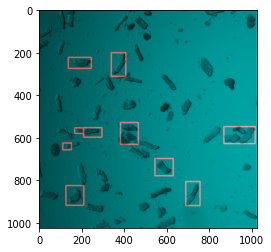

In [10]:
print(np.max(origImg))
plt.imshow(origImg)

In [ ]:
cellMask1 = binary_closing(cellMask0_mov,disk(3))
cellMask2 = ndi.binary_fill_holes(cellMask1)

cellMask3 =  remove_small_objects(cellMask2,50)

cellMask4 = binary_closing(cellMask3,disk(2))
cellMask5 = ndi.binary_fill_holes(cellMask4)

cellMask6 =  remove_small_objects(cellMask5,200)
cellMask7 = binary_dilation(cellMask6,disk(3))

seg_active0 = imreconstruct(seg_mov,seg,SE=disk(5))
seg_active1 = imreconstruct(seg,seg_mov,SE=disk(5))

seg_active = np.logical_or(seg_active0,seg_active1)

seg_active = remove_small_objects(seg_active,500)
seg_active = clear_border(seg_active)

fig,ax=plt.subplots(3,3,sharex=True,sharey=True,figsize=(18,18))
ax[0][0].imshow(cellMask0_mov)
ax[0][0].set_title('cellMask0')
ax[0][1].imshow(cellMask1)
ax[0][1].set_title('cellMask1')
ax[0][2].imshow(cellMask2)
ax[0][2].set_title('cellMask2')
ax[1][0].imshow(cellMask3)
ax[1][0].set_title('cellMask3')
ax[1][1].imshow(cellMask4)
ax[1][1].set_title('cellMask4')
ax[1][2].imshow(cellMask5)
ax[1][2].set_title('cellMask5')
ax[2][0].imshow(seg_active0)
ax[2][0].set_title('cellMask6')
ax[2][1].imshow(seg_active1)
ax[2][1].set_title('cellMask7')
ax[2][2].imshow(seg_active)
ax[2][2].set_title('seg_active')

In [ ]:
seg_label=label(seg_active)
seg_box=np.zeros(seg_active.shape,dtype = int)
props=regionprops(seg_label)
print(len(props))
for ii in range(len(props)):
    seg_box[props[ii].bbox[0]-1:props[ii].bbox[2]-1,props[ii].bbox[1]-1]=1
    seg_box[props[ii].bbox[0]-1:props[ii].bbox[2]-1,props[ii].bbox[3]-1]=1
    seg_box[props[ii].bbox[0]-1,props[ii].bbox[1]-1:props[ii].bbox[3]-1]=1
    seg_box[props[ii].bbox[2]-1,props[ii].bbox[1]-1:props[ii].bbox[3]-1]=1
    ###seg_box[props[ii].bbox[0]:props[ii].bbox[2],props[ii].bbox[1]:props[ii].bbox[3]]=1
seg_box = binary_dilation(seg_box,disk(5))
seg_box = seg_box.astype(int)*222
print(np.max(seg_box))



In [ ]:
img_man[:,:,1] = img_man[:,:,1]+seg_box
fig,ax=plt.subplots(1,3,sharex=True,sharey=True,figsize=(18,18))
ax[0].imshow(img_man.astype(int))
ax[0].set_title('Manual vs algorithm annotation')
ax[1].imshow(seg_box)
ax[1].set_title('algorithm annotation')
ax[2].imshow(seg)
ax[2].set_title('algorithm annotation')

In [ ]:
###for subfolder in subfolders:
subfolder=subfolders[0]
print(subfolder)
interFrame=10
ds_time = interFrame 

imageNameRoot =  subfolder  + "\\tiff\\*.tif"
    #B9, C2,C4
(dirName,videoFileName) = os.path.split(subfolder)

imageNameRoot0 = dirName
imageNames = sorted(glob.glob(imageNameRoot))
imageNum = len(imageNames)
print(dirName)
print(imageNames[0])
print(imageNum)
fps=100.0
if imageNum>1500:
    fps=200.0
    

In [ ]:
kk = 0
stackLen = len(imageNames)//ds_time
img0 = cv2.imread(imageNames[0])
img1 = cv2.cvtColor(img0, cv2.COLOR_BGR2GRAY)
reg_hei,reg_wid = img1.shape
imgStack = np.zeros([reg_hei, reg_wid, int(stackLen)+1],dtype =  np.float32)

for ii in range(0,imageNum,ds_time):
    img0 = cv2.imread(imageNames[ii])
    img1 = cv2.cvtColor(img0, cv2.COLOR_BGR2GRAY)
    imgStack[:,:,kk]=img1
    kk = kk+1

imgStack.astype(np.float32)
plt.imshow(imgStack[:,:,0])

In [ ]:
from scipy.fftpack import fftn,fftfreq

# sample spacing
T = 1.0 / stackLen*ds_time

# Number of sample points
N = stackLen
print(imgStack.shape)
print(T)
print(stackLen)

xf = fftfreq(N, T)[:N//2]

freq_range = np.where((np.array(xf)>0.5) & (np.array(xf)<1.5)) ##only check freqency domain from 0.5hz to 1.5hz

print(freq_range[0])
print(type(freq_range))
print(imgStack.dtype)
print(imgStack.shape)
imgStackFFT =np.abs(fftn(imgStack, axes=2))
print(imgStackFFT.shape)
imgFFTMax= np.max(imgStackFFT[:,:,freq_range[0]],axis=2)
print(imgStackFFT.shape)
print(imgFFTMax.shape)

In [ ]:
plt.imshow(imgFFTMax)

In [ ]:
plt.imshow(np.log(imgFFTMax+1))

print(np.max(np.log(imgFFTMax)))
print(np.median(np.log(imgFFTMax)))
print(np.mean(np.log(imgFFTMax)))
print(np.std(np.log(imgFFTMax)))
print(np.percentile(np.log(imgFFTMax[:]),95))

print(np.max(imgFFTMax))
print(np.median(imgFFTMax))
print(np.mean(imgFFTMax))
print(np.std(imgFFTMax))
print(np.percentile(imgFFTMax[:],95))

In [ ]:
th = np.mean(imgFFTMax)+3*np.std(imgFFTMax)
th_log=np.mean(np.log(imgFFTMax))+3*np.std(np.log(imgFFTMax))
plt.imshow(imgFFTMax>th)

In [ ]:
plt.imshow(np.log(imgFFTMax)>th_log)

In [ ]:
plt.plot(xf[1:N//2],np.mean(np.mean(imgStackFFT[120:250,0:50,1:N//2],axis=0),axis=0))

In [ ]:
plt.plot(xf[1:N//2],np.mean(np.mean(imgStackFFT[350:450,950:1010,1:N//2],axis=0),axis=0))
print(freq_range)
print(type(freq_range))

In [ ]:
plt.plot(xf[freq_range[0]],np.mean(np.mean(imgStackFFT[350:450,950:1010,freq_range[0]],axis=0),axis=0))

In [ ]:
plt.imshow(np.log(imgFFTMax)>th_log)

In [ ]:
plt.plot(imgStackFFT[50,50,2:])

In [ ]:
plt.imshow(np.real(imgStackFFT[:,:,100]))

In [ ]:
movingCellDetection(subfolder,fps=100.0,interFrame=1):
    print(subfolder)    
    # Downsampling in resolution
    ds_res = 1
    # Downsampling in time
    ds_time = interFrame 
##for subfolder in subfolders[0:len(subfolders):1]:
##for subfolder in subfolders[49:72]:
    imageNameRoot =  subfolder  + "\\tiff\\*.tif"
    #B9, C2,C4
    (dirName,videoFileName) = os.path.split(subfolder)

    imageNameRoot0 = dirName
    videoName = videoFileName
    # Output video frame rate (needs to check the true image acqusition frequency and the ds_time defined below)
        
    videoOut = subfolder+'\\' + videoName + '_video_ds.avi'

    imageNames = sorted(glob.glob(imageNameRoot))
    imageNum = len(imageNames)
    
    if imageNum>1500:
        fps=200.0
    img0 = cv2.imread(imageNames[0])
    img1 = cv2.cvtColor(img0, cv2.COLOR_BGR2GRAY)
    img = img1[::ds_res,::ds_res]

    hei, wid = img.shape

    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    VideoOutput = cv2.VideoWriter(videoOut, fourcc, fps, (wid,hei))


    mm = 0
    tic = time.time()

    for jj in range(0,imageNum-1,interFrame):
        img0 = cv2.imread(imageNames[jj])
        img1 = cv2.cvtColor(img0, cv2.COLOR_BGR2GRAY)
        img = img1[::ds_res,::ds_res]
         
        frame_final = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR) 

        #frame_final=np.concatenate((frame_final,vis),axis=1) 

        VideoOutput.write(frame_final)
        mm+=1
        if mm%100==0:
            print(mm)
    toc = time.time()
    print(toc-tic)     

In [ ]:
img_annotated = cv2.imread('.\\subDataSetOutput\\Plate1_Matrigel_s01_video_ds\\Plate1_Matrigel_s01_frame_0001_annotated.tif')
img_raw = cv2.imread('.\\subDataSetOutput\\Plate1_Matrigel_s01_video_ds\\Plate1_Matrigel_s01_frame_0001.tif')
mag_mean = cv2.imread('.\\subDataSetOutput\\Plate1_Matrigel_s01_video_ds\\Plate1_Matrigel_s01_video_ds_mean_activity.tif')
mag_max = cv2.imread('.\\subDataSetOutput\\Plate1_Matrigel_s01_video_ds\\Plate1_Matrigel_s01_video_ds_max_activity.tif')
img_enhance = exposure.equalize_adapthist(img_raw,kernel_size=25)
print(img_annotated.shape)
print(img_raw.shape)
print(mag_mean.shape)

In [ ]:
binary_local=CellSegmentation(img_enhance,block_size=19,offset=0.2)
plt.imshow(binary_local)

In [ ]:
fig, ax = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(12, 12))
ax[0][0].imshow(img_raw)
ax[0][0].set_title('Image')
ax[0][1].imshow(img_annotated)
ax[0][1].set_title('Manual annotation')
ax[0][2].imshow(img_enhance)
ax[0][2].set_title('enhanced image')
ax[1][0].imshow(mag_mean*50)
ax[1][0].set_title('movement:mean')
ax[1][1].imshow(mag_max*10)
ax[1][1].set_title('movement:max')
ax[1][2].imshow(binary_local)
ax[1][2].set_title('cell segmentation')
fig.tight_layout()

plt.show()

In [ ]:
print(np.max(mag_mean[:,:,0]))
print(np.median(mag_mean[:,:,0]))
print(np.min(mag_mean[:,:,0]))
print(np.mean(mag_mean[:,:,0]))
print(np.std(mag_mean[:,:,0]))


In [ ]:
movement_local0=mag_mean[:,:,0]>np.mean(mag_mean[:,:,0])+np.std(mag_mean[:,:,0])*1.0
movement_local1 = binary_opening(movement_local0,disk(3))
movement_local2 = remove_small_objects(movement_local1,100)

move_cell = (movement_local2>0).astype(int)+(binary_local>0).astype(int)
fig, ax = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(9, 9))
ax[0][0].imshow(movement_local0)
ax[0][0].set_title('move segmentation 0')
ax[0][1].imshow(movement_local1)
ax[0][1].set_title('move segmentation 1')
ax[1][0].imshow(movement_local2)
ax[1][0].set_title('move segmentation 2')
ax[1][1].imshow(move_cell)
ax[1][1].set_title('move segmentation 2 plus cell segmentation')
fig.tight_layout()

plt.show()

In [ ]:
cells = reconstruction((movement_local2>0).astype(int),move_cell)
seg = np.logical_and(binary_local>0,cells>0)
plt.imshow(seg)

In [ ]:
seg_label=label(seg)
seg_box = seg.astype(int)
print(np.max(seg_box))
props = regionprops(seg_label)
for ii in range(len(props)):
###for ii in range(1):
    seg_box[props[ii].bbox[0]:props[ii].bbox[2],props[ii].bbox[1]:props[ii].bbox[3]] = 1


fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(12, 12))
ax[0].imshow(img_annotated)
ax[0].set_title('Manual annotation')
ax[1].imshow(seg_box)
ax[1].set_title('Automated annotation')
fig.tight_layout()

plt.show()